In [2]:
%pylab inline
from collections import namedtuple
from observations import multi_mnist
import pyro
import pyro.optim as optim
from pyro.infer import SVI
import pyro.distributions as dist
from pyro.util import ng_ones, ng_zeros
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.nn.functional import relu, sigmoid, softplus, grid_sample, affine_grid
import numpy as np

Populating the interactive namespace from numpy and matplotlib


C:\Users\ares\Anaconda3\envs\py35\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [5]:
inpath = '../../examples/air/data'
(X_np, _), _ = multi_mnist(inpath, max_digits=2, canvas_size=50, seed=42)

>> Downloading ../../examples/air/data\train-images-idx3-ubyte.gz.part 
>> [9.5 MB/9.5 MB] 105% @7.9 MB/s,[0s remaining, 1s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/train-images-idx3-ubyte.gz downloaded to ../../examples/air/data\train-images-idx3-ubyte.gz 
>> Downloading ../../examples/air/data\train-labels-idx1-ubyte.gz.part 
>> [28.2 KB/28.2 KB] 3630% @4.8 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/train-labels-idx1-ubyte.gz downloaded to ../../examples/air/data\train-labels-idx1-ubyte.gz 
>> Downloading ../../examples/air/data\t10k-images-idx3-ubyte.gz.part 
>> [1.6 MB/1.6 MB] 127% @5.4 MB/s,[0s remaining, 0s elapsed]        
URL https://storage.googleapis.com/cvdf-datasets/mnist/t10k-images-idx3-ubyte.gz downloaded to ../../examples/air/data\t10k-images-idx3-ubyte.gz 
>> Downloading ../../examples/air/data\t10k-labels-idx1-ubyte.gz.part 
>> [4.4 KB/4.4 KB] 23086% @6.4 MB/s,[0s remaining, 0s elapsed]

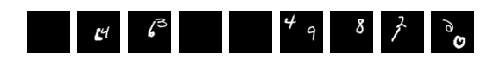

In [13]:
X_np = X_np.astype(np.float32)
X_np /= 255.0 
mnist = Variable(torch.from_numpy(X_np))
def show_images(imgs):
    figure(figsize=(8, 2))
    for i, img in enumerate(imgs):
        subplot(1, len(imgs), i+1)
        axis('off')
        imshow(img.data.numpy(), cmap='gray')
show_images(mnist[1:10])

In [60]:
# Create the neural network. This takes a latent code, z_what, to pixel intensities.
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(50, 200)
        self.l2 = nn.Linear(200, 400)

    def forward(self, z_what):
        h = relu(self.l1(z_what))
        return sigmoid(self.l2(h))

decode = Decoder()

z_where_prior_mu = Variable(torch.Tensor([3, 0, 0]))
z_where_prior_sigma = Variable(torch.Tensor([0.1, 1, 1]))
z_what_prior_mu = ng_zeros(50)
z_what_prior_sigma = ng_ones(50)

In [64]:
def prior_step_sketch(t):
    # Sample object pose. This is a 3-dimensional vector representing x,y position and size.
    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.normal,
                          z_where_prior_mu,
                          z_where_prior_sigma,
                          batch_size=1)

    # Sample object code. This is a 50-dimensional vector.
    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.normal,
                         z_what_prior_mu,
                         z_what_prior_sigma,
                         batch_size=1)

    # Map code to pixel space using the neural network.
    y_att = decode(z_what)

    # Position/scale object within larger image.
    y = object_to_image(z_where, y_att)

    return y

In [65]:
def expand_z_where(z_where):
    # Takes 3-dimensional vectors, and massages them into 2x3 matrices with elements like so:
    # [s,x,y] -> [[s,0,x],
    #             [0,s,y]]
    n = z_where.size(0)
    expansion_indices = Variable(torch.LongTensor([1, 0, 2, 0, 1, 3]))
    out = torch.cat((ng_zeros([1, 1]).expand(n, 1), z_where), 1)
    return torch.index_select(out, 1, expansion_indices).view(n, 2, 3)

def object_to_image(z_where, obj):
    n = obj.size(0)
    theta = expand_z_where(z_where)
    grid = affine_grid(theta, torch.Size((n, 1, 50, 50)))
    out = grid_sample(obj.view(n, 1, 20, 20), grid)
    return out.view(n, 50, 50)

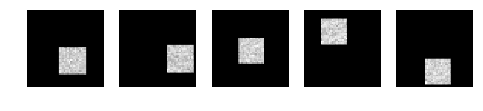

In [67]:
samples = [prior_step_sketch(0)[0] for _ in range(5)]
show_images(samples)

In [72]:
# We need to maintain uncertainty over the number of steps necessary to generate a point. 
# We could choose a geometric distribution as a prior:
def geom(num_trials=0):
    p = Variable(torch.Tensor([0.5]))
    x = pyro.sample('x{}'.format(num_trials), dist.bernoulli, p)
    if x.data[0] == 1:
        return num_trials
    else:
        return geom(num_trials + 1)
# Wikipedia defines the geometric distribution as
# The probability distribution of the number X of Bernoulli trials 
# needed to get one success, supported on the set { 1, 2, 3, ...}
    
for _ in range(5):
    print('sampled {}'.format(geom()))

sampled 1
sampled 1
sampled 2
sampled 1
sampled 1


In [73]:
def geom_prior(x, step=0):
    p = Variable(torch.Tensor([0.5]))
    i = pyro.sample('i{}'.format(step), dist.bernoulli, p)
    if i.data[0] == 1:
        return x
    else:
        x = x + prior_step_sketch(step)
        return geom_prior(x, step+1)

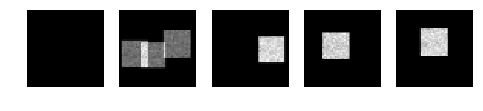

In [79]:
x_empty = ng_zeros(1, 50, 50)
samples = [geom_prior(x_empty)[0] for _ in range(5)]
show_images(samples)

In [81]:
def prior_step(n, t, prev_x, prev_z_pres):
    # Add objects until the first 0 is sampled
    z_pres = pyro.sample('z_pres_{}'.format(t), dist.bernoulli, 0.5 * prev_z_pres)
    z_where = pyro.sample('z_where_{}'.format(t), 
                         dist.normal, z_where_prior_mu, z_where_prior_sigma,
                         batch_size=n, log_pdf_mask=z_pres)
    
    z_what = pyro.sample('z_what_{}'.format(t),
                        dist.normal, z_what_prior_mu, z_what_prior_sigma,
                        batch_size=n, log_pdf_mask=z_pres)
    y_att = decode(z_what)
    y = object_to_image(z_where, y_att)
    
    x = prev_x + y * z_pres.view(-1, 1, 1)
    return x, z_pres

In [82]:
def prior(n):
    # Prior for number of steps
    x = ng_zeros(n, 50, 50)
    z_pres = ng_ones(n, 1)
    for t in range(3):
        x, z_pres = prior_step(n, t, x, z_pres)
    return x

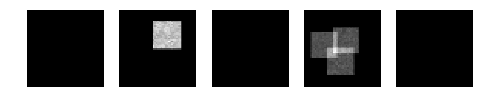

In [83]:
show_images(prior(5))

In [85]:
def model(data):
    pyro.module('decode', decode)
    with pyro.iarange('data', data.size(0)) as indices:
        batch = data[indices]
        x = prior(batch.size(0)).view(-1, 50*50)
        sd = (0.3 * ng_ones(1)).expand_as(x)
        pyro.sample('obs', dist.normal, x, sd, obs=batch)

In [102]:
# We will structure the guide around a recurrent network to allow the guide to capture (some of) 
# the dependencies we expect to be present in the true posterior
# ?????

rnn = nn.LSTMCell(2554, 256) # 2556 = 50^2 + 50 + 1 + 1

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(400, 200)
        self.l2 = nn.Linear(200, 100)

    def forward(self, data):
        h = relu(self.l1(data))
        a = self.l2(h)
        return a[:, 0:50], softplus(a[:, 50:]) #hmmmm
    
class Predict(nn.Module):
    def __init__(self, ):
        super(Predict, self).__init__()
        self.l = nn.Linear(256, 7)
    def forward(self, h):
        a = self.l(h)
        z_pres_p = sigmoid(a[:, 0:1])
        z_where_mu = a[:, 1:4]
        z_where_sigma = softplus(a[:, 4:])
        return z_pres_p, z_where_mu, z_where_sigma

encode = Encoder()
predict = Predict()

In [103]:
def guide_step_improved(t, data, prev):
    rnn_input = torch.cat((data, prev.z_where, prev.z_what, prev.z_pres), 1)
    h, c = rnn(rnn_input, (prev.h, prev.c))
    z_pres_p, z_where_mu, z_where_sigma = predict(h)
    
    z_pres = pyro.sample('z_pres_{}'.format(t),
                        dist.bernoulli, z_pres_p * prev.z_pres) # hmmm
    z_where = pyro.sample('z_where_{}'.format(t), 
                         dist.normal, z_where_mu, z_where_sigma)
    
    x_att = image_to_object(z_where, data)
    
    z_what_mu, z_what_sigma = encode(x_att)
    return
    z_what = pyro.sample('z_what_{}'.format(t),
                        dist.normal, z_what_mu, z_what_sigma)
    
    

In [104]:
def z_where_inv(z_where):
    # Take a batch of z_where vectors, and compute their "inverse".
    # That is, for each row compute:
    # [s,x,y] -> [1/s,-x/s,-y/s]
    # These are the parameters required to perform the inverse of the
    # spatial transform performed in the generative model.
    n = z_where.size(0)
    out = torch.cat((ng_ones([1, 1]).type_as(z_where).expand(n, 1), -z_where[:, 1:]), 1)
    out = out / z_where[:, 0:1]
    return out

def image_to_object(z_where, image):
    n = image.size(0)
    theta_inv = expand_z_where(z_where_inv(z_where))
    grid = affine_grid(theta_inv, torch.Size((n, 1, 20, 20)))
    out = grid_sample(image.view(n, 1, 50, 50), grid)
    return out.view(n, -1)

In [105]:
bl_rnn = nn.LSTMCell(2554, 256)
bl_predict = nn.Linear(256, 1)

# Use an RNN to compute the baseline value. This network takes the
# input images and the values samples so far as input.
def baseline_step(x, prev):
    rnn_input = torch.cat((x,
                           prev.z_where.detach(),
                           prev.z_what.detach(),
                           prev.z_pres.detach()), 1)
    bl_h, bl_c = bl_rnn(rnn_input, (prev.bl_h, prev.bl_c))
    bl_value = bl_predict(bl_h) * prev.z_pres
    return bl_value, bl_h, bl_c

In [106]:
GuideState = namedtuple('GuideState', ['h', 'c', 'bl_h', 'bl_c', 'z_pres', 'z_where', 'z_what'])
def initial_guide_state(n):
    return GuideState(h=ng_zeros(n, 256),
                      c=ng_zeros(n, 256),
                      bl_h=ng_zeros(n, 256),
                      bl_c=ng_zeros(n, 256),
                      z_pres=ng_ones(n, 1),
                      z_where=ng_zeros(n, 3),
                      z_what=ng_zeros(n, 50))

def guide_step(t, data, prev):

    rnn_input = torch.cat((data, prev.z_where, prev.z_what, prev.z_pres), 1)
    h, c = rnn(rnn_input, (prev.h, prev.c))
    z_pres_p, z_where_mu, z_where_sigma = predict(h)

    # Here we compute the baseline value, and pass it to sample.
    baseline_value, bl_h, bl_c = baseline_step(data, prev)
    z_pres = pyro.sample('z_pres_{}'.format(t),
                         dist.bernoulli,
                         z_pres_p * prev.z_pres,
                         baseline=dict(baseline_value=baseline_value))

    z_where = pyro.sample('z_where_{}'.format(t),
                          dist.normal, z_where_mu, z_where_sigma)

    x_att = image_to_object(z_where, data)

    z_what_mu, z_what_sigma = encode(x_att)

    z_what = pyro.sample('z_what_{}'.format(t),
                         dist.normal, z_what_mu, z_what_sigma)

    return GuideState(h=h, c=c, bl_h=bl_h, bl_c=bl_c, z_pres=z_pres, z_where=z_where, z_what=z_what)

def guide(data):
    # Register networks for optimization.
    pyro.module('rnn', rnn),
    pyro.module('predict', predict),
    pyro.module('encode', encode),
    pyro.module('bl_rnn', bl_rnn)
    pyro.module('bl_predict', bl_predict)

    with pyro.iarange('data', data.size(0), subsample_size=64) as indices:
        batch = data[indices]
        state = initial_guide_state(batch.size(0))
        steps = []
        for t in range(3):
            state = guide_step(t, batch, state)
            steps.append(state)
        return steps

In [108]:
data = mnist.view(-1, 50 * 50)

svi = SVI(model,
          guide,
          optim.Adam({'lr': 1e-4}),
          loss='ELBO',
          trace_graph=True)

for i in range(1000):
    loss = svi.step(data)
    print('i={}, elbo={:.2f}'.format(i, loss / data.size(0)))

i=0, elbo=4135.35
i=1, elbo=4022.18
i=2, elbo=2723.17
i=3, elbo=2416.25
i=4, elbo=4327.04
i=5, elbo=4080.99
i=6, elbo=3890.49
i=7, elbo=1426.39
i=8, elbo=1824.36
i=9, elbo=1777.56
i=10, elbo=3876.06
i=11, elbo=1621.49
i=12, elbo=2763.59
i=13, elbo=2642.77
i=14, elbo=4115.37
i=15, elbo=4103.30
i=16, elbo=1736.15
i=17, elbo=1754.78
i=18, elbo=2699.51
i=19, elbo=4040.55
i=20, elbo=2747.62
i=21, elbo=2172.60
i=22, elbo=3441.85
i=23, elbo=2495.26
i=24, elbo=3068.75
i=25, elbo=6568.18
i=26, elbo=3854.97
i=27, elbo=1496.97
i=28, elbo=2278.84
i=29, elbo=3905.28
i=30, elbo=1965.82
i=31, elbo=4126.85
i=32, elbo=3224.22
i=33, elbo=3835.77
i=34, elbo=2955.05
i=35, elbo=3623.90
i=36, elbo=2319.87
i=37, elbo=3000.08
i=38, elbo=2040.21
i=39, elbo=2603.77
i=40, elbo=3140.14
i=41, elbo=1758.71
i=42, elbo=2377.23
i=43, elbo=3835.48
i=44, elbo=3028.32
i=45, elbo=3249.78
i=46, elbo=3479.57
i=47, elbo=3182.66
i=48, elbo=2521.15
i=49, elbo=3090.84
i=50, elbo=2908.86
i=51, elbo=3136.87
i=52, elbo=2429.62
i=5

i=423, elbo=-394.20
i=424, elbo=-183.61
i=425, elbo=-395.25
i=426, elbo=-235.33
i=427, elbo=-334.45
i=428, elbo=-396.06
i=429, elbo=-342.91
i=430, elbo=-412.22
i=431, elbo=-329.39
i=432, elbo=-286.11
i=433, elbo=-368.42
i=434, elbo=-462.01
i=435, elbo=-282.52
i=436, elbo=-420.83
i=437, elbo=-341.48
i=438, elbo=-316.88
i=439, elbo=-434.37
i=440, elbo=-275.34
i=441, elbo=-349.99
i=442, elbo=-285.36
i=443, elbo=-201.03
i=444, elbo=-340.72
i=445, elbo=-463.69
i=446, elbo=-252.39
i=447, elbo=-399.97
i=448, elbo=-385.02
i=449, elbo=-540.39
i=450, elbo=-399.75
i=451, elbo=-330.39
i=452, elbo=-489.97
i=453, elbo=-459.40
i=454, elbo=-472.33
i=455, elbo=-481.91
i=456, elbo=-437.63
i=457, elbo=-506.72
i=458, elbo=-308.02
i=459, elbo=-342.50
i=460, elbo=-395.16
i=461, elbo=-361.82
i=462, elbo=-513.58
i=463, elbo=-419.42
i=464, elbo=-458.36
i=465, elbo=-272.75
i=466, elbo=-442.79
i=467, elbo=-393.05
i=468, elbo=-467.60
i=469, elbo=-421.81
i=470, elbo=-500.28
i=471, elbo=-554.27
i=472, elbo=-514.62


i=833, elbo=-314.21
i=834, elbo=-459.87
i=835, elbo=-505.80
i=836, elbo=-441.39
i=837, elbo=-559.11
i=838, elbo=-499.28
i=839, elbo=-440.85
i=840, elbo=-478.61
i=841, elbo=-502.37
i=842, elbo=-444.56
i=843, elbo=-513.76
i=844, elbo=-513.14
i=845, elbo=-613.89
i=846, elbo=-588.75
i=847, elbo=-442.03
i=848, elbo=-448.15
i=849, elbo=-538.27
i=850, elbo=-467.13
i=851, elbo=-556.27
i=852, elbo=-445.40
i=853, elbo=-447.49
i=854, elbo=-341.92
i=855, elbo=-328.24
i=856, elbo=-431.32
i=857, elbo=-559.45
i=858, elbo=-368.00
i=859, elbo=-529.34
i=860, elbo=-367.90
i=861, elbo=-405.22
i=862, elbo=-342.93
i=863, elbo=-500.37
i=864, elbo=-462.88
i=865, elbo=-680.80
i=866, elbo=-589.03
i=867, elbo=-454.22
i=868, elbo=-442.93
i=869, elbo=-372.82
i=870, elbo=-594.42
i=871, elbo=-428.62
i=872, elbo=-525.84
i=873, elbo=-543.45
i=874, elbo=-465.24
i=875, elbo=-513.59
i=876, elbo=-532.30
i=877, elbo=-567.27
i=878, elbo=-424.76
i=879, elbo=-507.29
i=880, elbo=-440.86
i=881, elbo=-430.80
i=882, elbo=-529.32
